In [47]:
import sys
import os
import numpy as np
import time
# Add the parent folder to sys.path
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

import pandas as pd
import density_generator
import numpy as np
import matplotlib.pyplot as plt
import qutip
import importlib
import helper_functions
import classicalQFI
import quantum_subroutines_pennylane
import pipeline_v200
import vqfe_subroutine
import pennylane as qml
import circuit_generator
from scipy.linalg import eigh
#from pennylane import numpy as np

from random import randint
importlib.reload(density_generator)
importlib.reload(helper_functions)
importlib.reload(quantum_subroutines_pennylane)
importlib.reload(vqfe_subroutine)
importlib.reload(pipeline_v200)
importlib.reload(circuit_generator)
importlib.reload(classicalQFI)

pass;

In [48]:
## parameters
N=3
n=2
#trace_out_indices= list(range(N - n))
trace_out_indices = np.sort(np.random.choice(range(N), size= N - n, replace=False))
#trace_out_indices = [0]
J=1
#h_z=0.1
h_x=0.1
delta=0.5
delta_h_x=0.5
m=1
# initial_state=None
DEBUG=False
derivative_delta=1e-3

print("N =",N, " starting number of qubits, before tracing out")
print("n =",n," final number of qubits")
print("trace_out_indices =",trace_out_indices)
print("J =",J)
#print("h_z =",h_z)
print("h_x =",h_x)
print("delta_h_x =",delta_h_x)
print("delta =",delta)
print("m =",m)
print("DEBUG is set to: ",DEBUG)

N = 3  starting number of qubits, before tracing out
n = 2  final number of qubits
trace_out_indices = [0]
J = 1
h_x = 0.1
delta_h_x = 0.5
delta = 0.5
m = 1
DEBUG is set to:  False


In [49]:
trace_out_indices

array([0])

In [50]:
# classical
print("TEST 1 : classical\n")
#model = density_generator.SpinChainXXZ(n=N, J=J, h_z=h_z, initial_state="0", DEBUG=DEBUG) 
model = density_generator.TransverseFieldIsingModel(n=N, J=J, h_x=h_x, initial_state="0", DEBUG=DEBUG) 
## using N because i will trace out

rho_pure, rho_delta_pure = model.generate_perturbed_density_matrices(delta_h_x==delta_h_x)
print("rho_pure shape = ", rho_pure.shape)
evals = np.linalg.eigvalsh(rho_pure)
entropy = -np.sum(evals * np.log2(evals + 1e-12))  # small epsilon for numerical stability
print("entanglement entropy = ", entropy)


rho_mixed, rho_delta_mixed = model.generate_mixed_states_with_perturbation(delta_h_x=delta_h_x,trace_out_indices=trace_out_indices)
print("rho_mixed shape = ", rho_mixed.shape)
print("purity of rho", np.trace(rho_mixed @ rho_mixed))
print("purity of rho_delta", np.trace(rho_delta_mixed @ rho_delta_mixed))

evals = np.linalg.eigvalsh(rho_mixed)
entropy = -np.sum(evals * np.log2(evals + 1e-12))  # small epsilon for numerical stability
print("entanglement entropy = ", entropy)

print("uhlmann fidelity = ", helper_functions.uhlmann_fidelity_root(rho_mixed, rho_delta_mixed))
print("fidelity pennylane = ",helper_functions.fidelity_pennylane(rho_mixed, rho_delta_mixed))


TEST 1 : classical

rho_pure shape =  (8, 8)
entanglement entropy =  -1.4428232973175175e-12
rho_mixed shape =  (4, 4)
purity of rho (1+0j)
purity of rho_delta (1+0j)
entanglement entropy =  -1.4428232973175175e-12
uhlmann fidelity =  1.0
fidelity pennylane =  1.0


TEST 2 : quantum



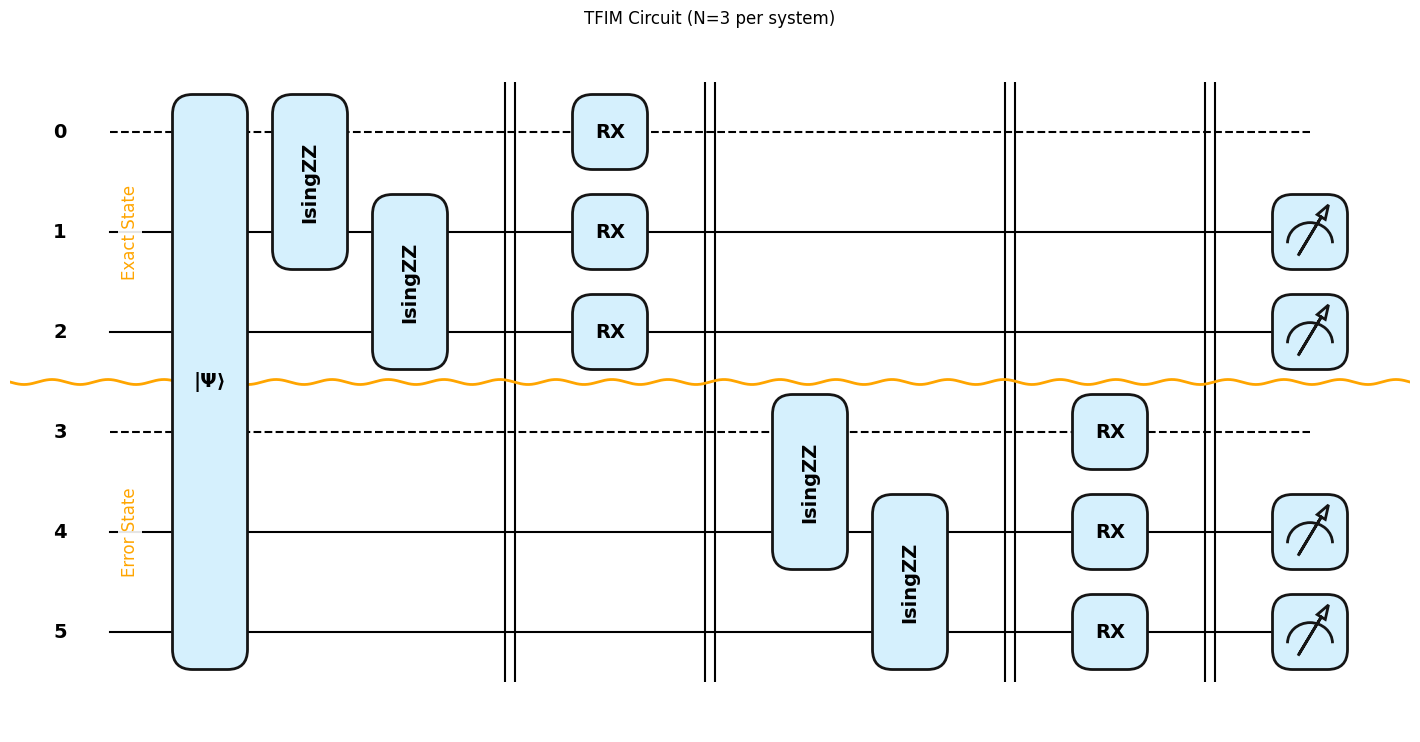

In [ ]:
print("TEST 2 : quantum\n")

DRAW = True



circuit_fn = circuit_generator.make_tfim_circuits(J, h_x, delta, N) 

# Attach to a device and QNode
dev = qml.device("default.qubit", wires=2 * N)

# --- Construct measured_wires ---
# These calculations correctly generate integer wire indices IF N is an int
# and trace_out_indices contains only ints.
active_rho = [x for x in list(range(N)) if x not in trace_out_indices] 
active_rho_delta = [x + N for x in active_rho] # Adds N (integer) to each active_rho (integer)

measured_wires = active_rho + active_rho_delta # Concatenates lists of integers
discarded_wires = [x for x in range(2*N) if x not in measured_wires] # Filters from integers


@qml.qnode(dev)
def qnode():
    circuit_fn()
    # It is crucial that `measured_wires` contains only integers or a single integer.
    # The TypeError "got '0.2'" means a float ended up in this list.
    return qml.density_matrix(wires=measured_wires) # This is where the error occurs


# --- Print the Circuit ---
wire_options = {
    i: {'linestyle': '--'} for i in discarded_wires # Highlight discarded wires
}

if DRAW:
    # Get the drawing function. Call it to get the fig and ax objects.
    # The `()` at the end is correct to call the drawing function.
    fig, ax = qml.draw_mpl(qnode, style="pennylane", wire_options=wire_options)()

    # --- Add a horizontal line at half of the plot ---
    # The wires are drawn from top (wire 0) to bottom (wire 2*N - 1).
    # The line should be between the N-th qubit and the (N+1)-th qubit (0-indexed).
    # Its y-coordinate will be N - 0.5 (assuming wire 0 is at y=0, wire 1 at y=1, etc.)
    
    # Calculate the y-coordinate for the horizontal separator
    # 'N' here is the number of qubits in the first system
    separator_y = N - 0.5 
    
    # Add the horizontal line to the axes
    # Adjust xmin and xmax to make the line span the desired width.
    # These are normalized coordinates (0 to 1) relative to the axes' width.
    #ax.axhline(y=separator_y, color='red', linewidth=2.0, xmin=0.05, xmax=0.95)
    
    # dotted separator
    #ax.axhline(y=separator_y, color='red', linewidth=2.0, xmin=0.05, xmax=0.95,
    #       linestyle=(0, (1, 10))) # This makes it a dotted line, which can look "wavy" from a distance
    
    # --- Parameters for the sinusoidal line ---
    # `separator_y` is the central y-position for the wave
    # It sits between wire N-1 and wire N.
    separator_y = N - 0.5 
    
    # Get the x-limits of the plot to span the wave across the circuit
    x_min, x_max = ax.get_xlim() 

    # Amplitude of the wave (how "tall" it is). Adjust this to your liking.
    # A value between 0.1 and 0.3 usually looks good without overlapping wires.
    amplitude = 0.025

    # Frequency of the wave (how many cycles across the plot). Adjust this.
    # E.g., 5 cycles across the x_range.
    num_cycles = 25 
    
    # Generate x values for the sine wave. Use many points for a smooth curve.
    x_wave = np.linspace(x_min, x_max, 500) 

    # Calculate y values for the sine wave.
    # This formula creates a sine wave centered at `separator_y`
    # and scales it to fit `num_cycles` within the `x_min` to `x_max` range.
    y_wave = separator_y + amplitude * np.sin(2 * np.pi * num_cycles * (x_wave - x_min) / (x_max - x_min))

    # Plot the sinusoidal line
    ax.plot(x_wave, y_wave, color='orange', linewidth=2.0, linestyle='-') # Use solid linestyle for the wave

    # --- Add text labels ---
    # Adjust text position based on the diagram's layout and number of wires
    ax.text(-0.8, (N - 1)/2, 'Exact State', ha='center', va='center', fontsize=12, rotation=90, color='orange',
        bbox=dict(facecolor='white', alpha=0.9, edgecolor='none', pad=2))
    ax.text(-0.8, N + (N - 1)/2, 'Error State', ha='center', va='center', fontsize=12, rotation=90,color='orange',
        bbox=dict(facecolor='white', alpha=0.9, edgecolor='none', pad=2 ))

    plt.title(f"TFIM Circuit (N={N} per system)")
    plt.show()

# You can still execute the QNode if needed:
# result_dm = qnode()
# print("\nResulting density matrix for measured wires:\n", np.round(result_dm, 4))
 

In [73]:
vqfe_results = vqfe_subroutine.vqfe_from_circuit_disjoint(
    circuit_fn = circuit_fn,
    total_num_qubits=2*N,
    active_rho_wires = active_rho, 
    active_rho_delta_wires = active_rho_delta,
    L=2, 
    m=1, 
    maxiter=200)
vqfe_results


{'F_trunc': tensor(0.73832667, requires_grad=True),
 'F_star': tensor(0.79088964, requires_grad=True),
 'top_eigenvalues_rho': tensor([0.99388093], requires_grad=True),
 'trace_rho_m': tensor(0.99388093, requires_grad=True),
 'trace_sigma_m': 0.5484824759806627,
 'opt_params': array([[[-0.66963918,  0.12728629,  0.14381921],
         [-0.31889132, -0.2241761 , -0.31732972]],
 
        [[ 0.12134038,  0.00887173,  0.97666795],
         [-0.27333626,  0.32802575,  0.17392781]]]),
 'rho_rotated_final': array([[ 9.93880934e-01+8.69157448e-17j, -7.32618788e-03+1.72928740e-03j,
          6.71278892e-02+3.08507172e-02j, -2.10635189e-02-1.11071032e-02j],
        [-7.32618788e-03-1.72928740e-03j,  5.70123260e-05-2.13595405e-18j,
         -4.41141143e-04-3.44207794e-04j,  1.35939747e-04+1.18522852e-04j],
        [ 6.71278892e-02-3.08507172e-02j, -4.41141143e-04+3.44207794e-04j,
          5.49152325e-03+5.71853119e-19j, -1.76742666e-03-9.63613683e-05j],
        [-2.10635189e-02+1.11071032e-02j,  

In [32]:
# collect fidelities

## parameters
N=4
n=3
trace_out_indices = np.random.choice(range(N), size= N - n, replace=False)
J=1
delta=0.5
m=2
# initial_state=None
DEBUG=False
derivative_delta=1e-3


# indices for quantum part
# trace out for the whole system composed by sys 1 and sys 2
active_rho = [x for x in list(range(N)) if x not in trace_out_indices] 
active_rho_delta = [x + N for x in active_rho]

measured_wires = active_rho + active_rho_delta
discarded_wires = [x for x in range(2*N) if x not in measured_wires]



results = []

for h_z in np.linspace(0, 2.5, 20):

    # classical fidelity
    # classical

    model = density_generator.SpinChainXXZ(n=N, J=J, h_z=h_z, initial_state="0", DEBUG=DEBUG) 
    
    rho_mixed, rho_delta_mixed = model.generate_mixed_density_matrices_with_perturbation(delta=delta,trace_out_indices=trace_out_indices)

    classical_results = classicalQFI.compute_tqfi_bounds(rho_mixed, rho_delta_mixed, m, delta, DEBUG=False)
    
    # quantum fidelity

    circuit_fn = circuit_generator.make_xx_plus_z_circuits(J, h_z, delta, N) 

    # Attach to a device and QNode
    dev = qml.device("default.qubit", wires=2 * N)
    vqfe_results = vqfe_subroutine.vqfe_from_circuit_disjoint(
        circuit_fn = circuit_fn,
        total_num_qubits=2*N,
        active_rho_wires = active_rho, 
        active_rho_delta_wires = active_rho_delta,
        L=2, 
        m=m, 
        maxiter= 256)

    results.append({
        "hz": h_z,
        "(Classical) uhlmann_fidelity": classical_results["uhlmann_fidelity"],
        "(Classical) pennylane_fidelity": classical_results["fidelity_pennylane"],
        "(Classical) fidelity_truncated":classical_results["fidelity_truncated"],
        "(Classical) fidelity_truncated_generalized": classical_results["fidelity_truncated_generalized"],
        #"(Classical) Participation Ratio" : classical_results["F_trunc"],
        "(Quantum) F_trunc" : vqfe_results["F_trunc"].item(),
        "(Quantum) F_star" : vqfe_results["F_star"].item(),

    })

    # quantum fidelity
    

df = pd.DataFrame(results)

    

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


KeyboardInterrupt: 

/home/ronin/miniforge3/envs/space/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/ronin/miniforge3/envs/space/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


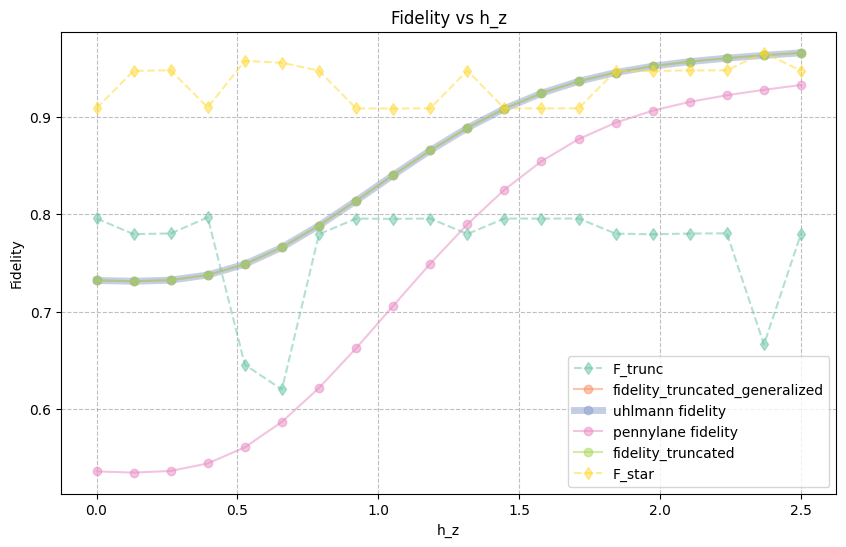

In [56]:
# plot fidelities
import seaborn as sns
sns.set_palette("Set2")
plt.figure(figsize=(10, 6))
plt.plot(df["hz"], df["(Quantum) F_trunc"], label="F_trunc", marker='d', linestyle='--', alpha=0.5)
plt.plot(df["hz"], df["(Classical) fidelity_truncated_generalized"], label="fidelity_truncated_generalized", marker='o', alpha=0.5)
plt.plot(df["hz"], df["(Classical) uhlmann_fidelity"], label="uhlmann fidelity", marker='o', linewidth=5, alpha=0.5)
plt.plot(df["hz"], df["(Classical) pennylane_fidelity"], label="pennylane fidelity", marker='o', alpha=0.5)
plt.plot(df["hz"], df["(Classical) fidelity_truncated"], label="fidelity_truncated", marker='o', alpha=0.5)
plt.plot(df["hz"], df["(Quantum) F_star"], label="F_star", marker='d', linestyle='--', alpha=0.5)
plt.xlabel("h_z")
plt.ylabel("Fidelity")
plt.title("Fidelity vs h_z")
plt.legend()
# use a discomtinuous line style grid
plt.grid(
    linestyle='--',
    color='gray',
    alpha=0.5
)
plt.show()

In [10]:
uhlmann_fidelity = df["(Classical) uhlmann_fidelity"].values
uhlmann_fidelity

array([0.73195257, 0.7311377 , 0.7322808 , 0.73755258, 0.74865686,
       0.76595599, 0.78834086, 0.81380086, 0.84015555, 0.86555002,
       0.8886084 , 0.90837373, 0.92433495, 0.93655104, 0.94555049,
       0.95205583, 0.95677994, 0.96034065, 0.96323332, 0.96581945])

In [ ]:
# compare states

## parameters
N=3
n=2
trace_out_indices = np.random.choice(range(N), size= N - n, replace=False)
J=1
delta=0.5
m=1
# initial_state=None
DEBUG=False
derivative_delta=1e-3


# indices for quantum part
# trace out for the whole system composed by sys 1 and sys 2
active_rho = [x for x in list(range(N)) if x not in trace_out_indices] 
active_rho_delta = [x + N for x in active_rho]

measured_wires = active_rho + active_rho_delta
discarded_wires = [x for x in range(2*N) if x not in measured_wires]
h_z = 0.1


results = []


# classical fidelity
# classical

model = density_generator.SpinChainXXZ(n=N, J=J, h_z=h_z, initial_state="0", DEBUG=DEBUG) 

rho_mixed, rho_delta_mixed = model.generate_mixed_density_matrices_with_perturbation(delta=delta,trace_out_indices=trace_out_indices)

print(f"purity of rho_mixed: {np.trace(rho_mixed @ rho_mixed)}")
print(f"partcipation ratio of rho_mixed: {1/ np.trace(rho_mixed @ rho_mixed)}")

qobj_1 = helper_functions.dm_to_qobj(rho_mixed, title="rho_mixed")

classical_results = classicalQFI.compute_tqfi_bounds(rho_mixed, rho_delta_mixed, m, delta, DEBUG=False)

# quantum fidelity

circuit_fn = circuit_generator.make_xx_plus_z_circuits(J, h_z, delta, N) 
q_dm = circuit_generator.get_density_matrix_circuit(circuit_factory=circuit_fn,
                                                    active_qubits=active_rho)
# Load a device
dev = qml.device("default.qubit", wires=2 * N)

# Create the QNode for the density matrix circuit
density_matrix_qnode = qml.QNode(q_dm, dev)

# Execute the QNode to get the density matrix
quantum_density_matrix = density_matrix_qnode()
qobj_2 = helper_functions.dm_to_qobj(quantum_density_matrix, title="quantum_density_matrix")

print(f"Density matrix of qubits {active_rho}:\n")


# Attach to a device and QNode
dev = qml.device("default.qubit", wires=2 * N)
vqfe_results = vqfe_subroutine.vqfe_from_circuit_disjoint(
    circuit_fn = circuit_fn,
    total_num_qubits=2*N,
    active_rho_wires = active_rho, 
    active_rho_delta_wires = active_rho_delta,
    L=2, 
    m=m, 
    maxiter= 256)

results.append({
    "hz": h_z,
    "(Classical) uhlmann_fidelity": classical_results["uhlmann_fidelity"],
    "(Classical) pennylane_fidelity": classical_results["fidelity_pennylane"],
    "(Classical) fidelity_truncated":classical_results["fidelity_truncated"],
    "(Classical) fidelity_truncated_generalized": classical_results["fidelity_truncated_generalized"],
    "(Quantum) F_trunc" : vqfe_results["F_trunc"].item(),
    "(Quantum) F_star" : vqfe_results["F_star"].item(),

})

# quantum fidelity
df = pd.DataFrame(results)


purity of rho_mixed: (0.5807337467785696+0j)
partcipation ratio of rho_mixed: (1.7219595133693757+0j)
Density matrix of qubits [1, 2]:



In [ ]:
qobj_1


Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.0947817 +0.j         0.        +0.j         0.        +0.j
  0.05320086+0.12858411j]
 [0.        +0.j         0.49661188+0.j         0.03732097-0.31633297j
  0.        +0.j        ]
 [0.        +0.j         0.03732097+0.31633297j 0.20430321+0.j
  0.        +0.j        ]
 [0.05320086-0.12858411j 0.        +0.j         0.        +0.j
  0.20430321+0.j        ]]

In [53]:
qobj_2

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 8.52211291e-02+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          5.16851775e-02+0.12224694j]
 [ 0.00000000e+00+0.j          5.01367966e-01+0.j
  -1.99493200e-17-0.32192467j  0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j         -1.99493200e-17+0.32192467j
   2.06705453e-01+0.j          0.00000000e+00+0.j        ]
 [ 5.16851775e-02-0.12224694j  0.00000000e+00+0.j
   0.00000000e+00+0.j          2.06705453e-01+0.j        ]]